In [2]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

In [3]:
### UTLITY FUNCTIONS FOR SYNTETIC DATA GENERATION ###

def gen_sinusoidal(timesteps, amp, freq, noise):
    
    X = np.arange(timesteps)
    e = np.random.normal(0,noise, (timesteps,))
    y = amp*np.sin(X*(2*np.pi/freq))+e
    
    return y


def gen_randomwalk(timesteps, noise):

    y = np.random.normal(0,noise, (timesteps,))
    
    return y.cumsum()

In [4]:
### SYNTETIC DATA GENERATION ###

df = {}
n_series = 100
timesteps = 2_000
for i in range(n_series):
    
    np.random.seed(i)
    seas1 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24, noise=4)
    seas2 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24*7, noise=4)
    
    rw = gen_randomwalk(timesteps=timesteps, noise=1)
    X = np.linspace(0,10, timesteps).reshape(-1,1)
    X = np.power(X, [1,2,3])
    m = LinearRegression()
    trend = m.fit(X, rw).predict(X)

    df[f'ts_{i}'] = seas1 + seas2 + trend
    
df = pd.DataFrame(df) + 3_000
df.shape

(2000, 100)

Text(0.5, 1.0, 'Seasonalities + Trend')

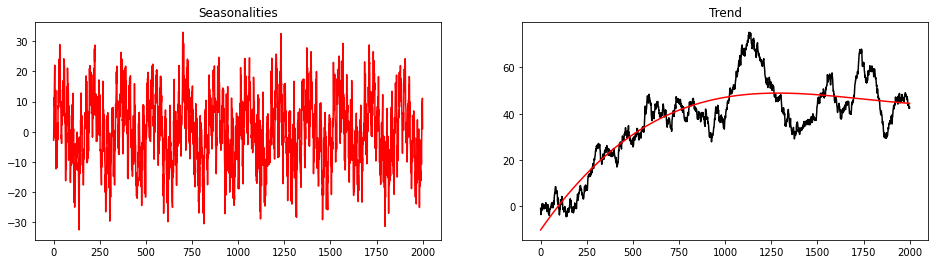

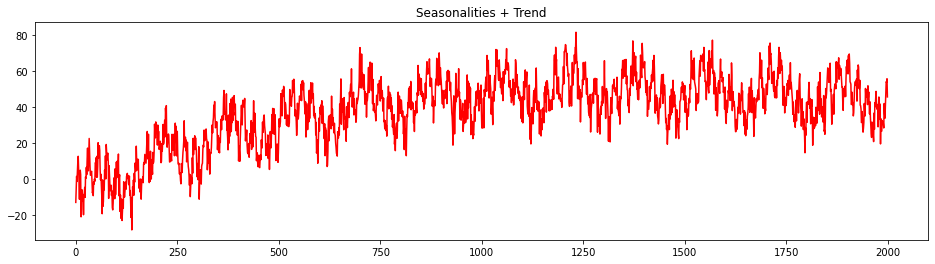

In [5]:
### EXAMPLE OF SYNTETIC DATA GENERATION ###

np.random.seed(1234)
seas1 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24, noise=4)
seas2 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24*7, noise=4)

rw = gen_randomwalk(timesteps=timesteps, noise=1)
X = np.linspace(0,10, timesteps).reshape(-1,1)
X = np.power(X, [1,2,3])
m = LinearRegression()
trend = m.fit(X, rw).predict(X)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(seas1 + seas2, c='red'); plt.title('Seasonalities')
plt.subplot(122)
plt.plot(rw, c='black'); plt.plot(trend, c='red'); plt.title('Trend')

plt.figure(figsize=(16,4))
plt.plot(seas1 + seas2 + trend, c='red'); plt.title('Seasonalities + Trend')

<AxesSubplot:>

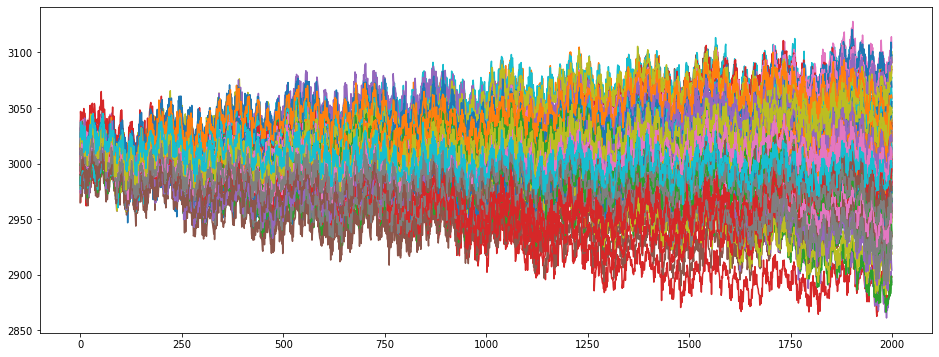

In [6]:
### PLOT GENERATED DATA ###

df.plot(legend=False, figsize=(16,6))

In [7]:
### FIT MODELS AND STORE RESULTS ###

mse_naive = []
mse_diff = []
mse_hybrid_add = []
mse_hybrid_incl = []

df_naive = (df*np.nan).copy()
df_diff = (df*np.nan).copy()
df_hybrid_add = (df*np.nan).copy()
df_hybrid_incl = (df*np.nan).copy()

ts = tqdm(df.columns)
for c in ts:
    
    y_test = df[c].tail(24*7*4)
    y_train = df[c][~df[c].index.isin(y_test.index)]
    X_train = np.arange(0, y_train.shape[0]).reshape(-1,1)
    X_test = np.arange(X_train[-1], X_train[-1]+y_test.shape[0]).reshape(-1,1)
    
    train_mask = df[c].index.isin(y_train.index)
    test_mask = df[c].index.isin(y_test.index)
    
    period = 24
    n_splines = 3
    n_knots = n_splines +1
    st24 = SplineTransformer(
        degree = 3,
        n_knots = n_knots,
        knots = np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation = "periodic",
        include_bias = True,
    )
    period = 168
    n_splines = 6
    n_knots = n_splines +1
    st168 = SplineTransformer(
        degree = 3,
        n_knots = n_knots,
        knots = np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation = "periodic",
        include_bias = True,
    )
    
    CV = TimeSeriesSplit(n_splits=4)
    base_model = LGBMRegressor(random_state=33, n_jobs=-1) 
    param_grid = {'n_estimators': [30,50,70,90,110,130]}
    
    trend2 = (-cross_val_score(
        LinearRegression(), np.power(X_train,[1,2]), y_train, 
        cv=CV, scoring='neg_mean_squared_error'
    )).mean()
    trend3 = (-cross_val_score(
        LinearRegression(), np.power(X_train,[1,2,3]), y_train, 
        cv=CV, scoring='neg_mean_squared_error'
    )).mean()
    
    powers = [1,2] if trend2 <= trend3 else [1,2,3]

    trend = LinearRegression() 
    trend.fit(np.power(X_train,powers), y_train)
    train_trend = trend.predict(np.power(X_train,powers))
    test_trend = trend.predict(np.power(X_test,powers))
    
    df_naive.loc[train_mask, c] = train_trend
    df_naive.loc[test_mask, c] = test_trend
    mse_naive.append(mse(y_test, trend.predict(np.power(X_test,powers))))
    score_naive = f"Naive Trend: {round(np.mean(mse_naive),3)}"
    
    X_train = np.hstack([st24.fit_transform(X_train), st168.fit_transform(X_train)])
    X_test = np.hstack([st24.transform(X_test), st168.transform(X_test)])
    
    model = GridSearchCV(base_model, param_grid=param_grid, cv=CV, scoring='neg_mean_squared_error')
    model.fit(X_train[1:], np.diff(y_train))
    
    df_diff.loc[train_mask, c] = np.cumsum(np.append(y_train.head(1), model.predict(X_train[1:])))
    df_diff.loc[test_mask, c] = np.cumsum(np.append(y_train.tail(1), model.predict(X_test)))[1:]
    mse_diff.append(mse(y_test, np.cumsum(np.append(y_train.tail(1), model.predict(X_test)))[1:]))
    score_diff = f"Differencing: {round(np.mean(mse_diff),3)}"
    
    model = GridSearchCV(base_model, param_grid=param_grid, cv=CV, scoring='neg_mean_squared_error')
    model.fit(X_train, y_train-train_trend)
    
    df_hybrid_add.loc[train_mask, c] = model.predict(X_train)+train_trend
    df_hybrid_add.loc[test_mask, c] = model.predict(X_test)+test_trend    
    mse_hybrid_add.append(mse(y_test, model.predict(X_test)+test_trend))
    score_hybrid_add = f"Hybrid Additive: {round(np.mean(mse_hybrid_add),3)}"
    
    X_train = np.hstack([train_trend.reshape(-1,1), X_train])
    X_test = np.hstack([test_trend.reshape(-1,1), X_test]) 
    
    model = GridSearchCV(base_model, param_grid=param_grid, cv=CV, scoring='neg_mean_squared_error')
    model.fit(X_train, y_train)
    
    df_hybrid_incl.loc[train_mask, c] = model.predict(X_train)
    df_hybrid_incl.loc[test_mask, c] = model.predict(X_test)     
    mse_hybrid_incl.append(mse(y_test, model.predict(X_test)))
    score_hybrid_incl = f"Hybrid Inclusive: {round(np.mean(mse_hybrid_incl),3)}"
    
    desc = f"{score_naive} | {score_diff} | {score_hybrid_add} | {score_hybrid_incl} |"
    ts.set_description(desc)

Naive Trend: 1353.755 | Differencing: 473.041 | Hybrid Additive: 1251.465 | Hybrid Inclusive: 427.517 |: 100%|██████████| 100/100 [05:45<00:00,  3.45s/it]


<AxesSubplot:title={'center':'MSEs on Test'}, ylabel='MSE'>

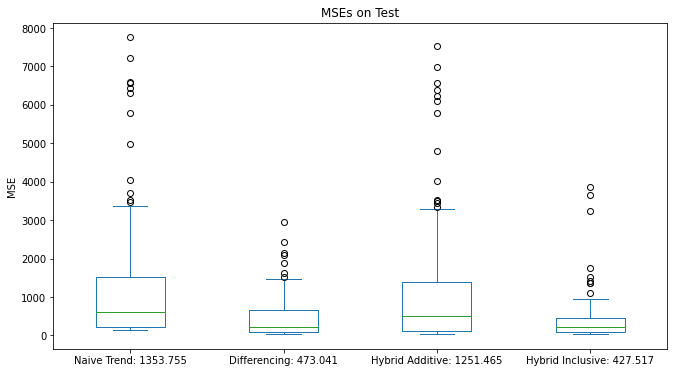

In [8]:
### TEST ERROR DISTRIBUTIONS ###

scores = pd.DataFrame({
    f'{score_naive}': mse_naive,
    f'{score_diff}': mse_diff,
    f'{score_hybrid_add}': mse_hybrid_add,
    f'{score_hybrid_incl}': mse_hybrid_incl
})

scores.plot.box(figsize=(11,6), title='MSEs on Test', ylabel='MSE')

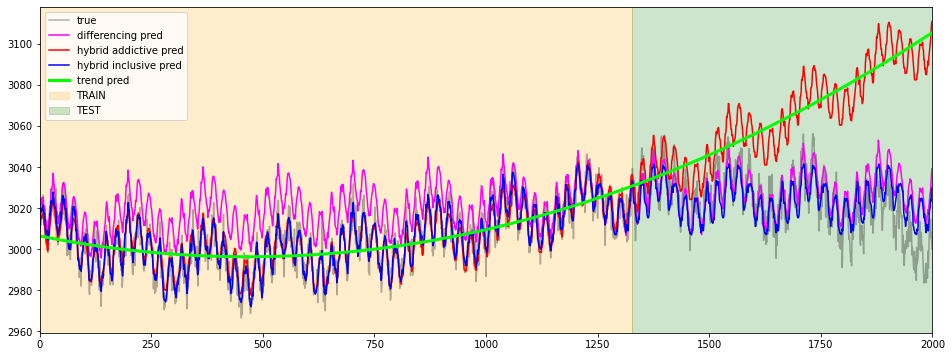

In [9]:
### PLOT PREDICTIONS ###

c = 'ts_11' 

df[c].plot(figsize=(16,6), label='true', alpha=0.3, c='black')

df_diff[c].plot(figsize=(16,6), label='differencing pred', c='magenta')
df_hybrid_add[c].plot(figsize=(16,6), label='hybrid addictive pred', c='red')
df_hybrid_incl[c].plot(figsize=(16,6), label='hybrid inclusive pred', c='blue')
df_naive[c].plot(figsize=(16,6), label='trend pred', c='lime', linewidth=3)

plt.xlim(0, timesteps)
plt.axvspan(0, timesteps-test_mask.sum(), alpha=0.2, color='orange', label='TRAIN')
plt.axvspan(timesteps-test_mask.sum(), timesteps, alpha=0.2, color='green', label='TEST')
plt.legend()

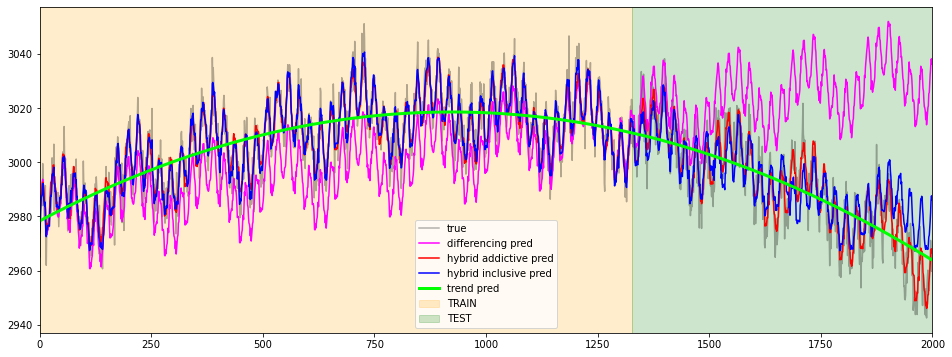

In [10]:
### PLOT PREDICTIONS ###

c = 'ts_33' 

df[c].plot(figsize=(16,6), label='true', alpha=0.3, c='black')

df_diff[c].plot(figsize=(16,6), label='differencing pred', c='magenta')
df_hybrid_add[c].plot(figsize=(16,6), label='hybrid addictive pred', c='red')
df_hybrid_incl[c].plot(figsize=(16,6), label='hybrid inclusive pred', c='blue')
df_naive[c].plot(figsize=(16,6), label='trend pred', c='lime', linewidth=3)

plt.xlim(0, timesteps)
plt.axvspan(0, timesteps-test_mask.sum(), alpha=0.2, color='orange', label='TRAIN')
plt.axvspan(timesteps-test_mask.sum(), timesteps, alpha=0.2, color='green', label='TEST')
plt.legend()

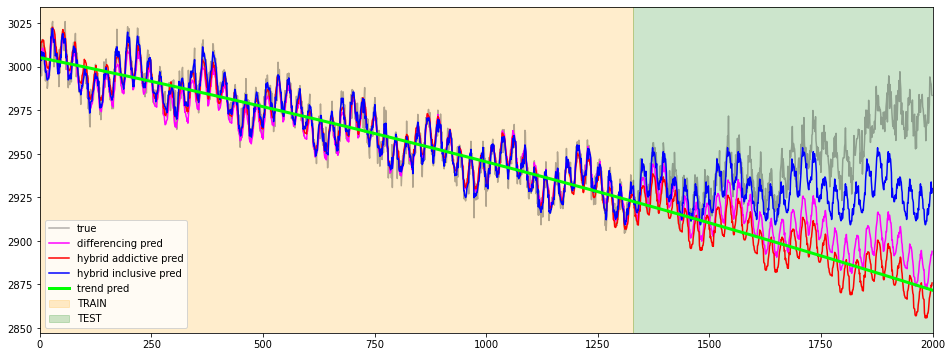

In [11]:
### PLOT PREDICTIONS ###

c = 'ts_73' 

df[c].plot(figsize=(16,6), label='true', alpha=0.3, c='black')

df_diff[c].plot(figsize=(16,6), label='differencing pred', c='magenta')
df_hybrid_add[c].plot(figsize=(16,6), label='hybrid addictive pred', c='red')
df_hybrid_incl[c].plot(figsize=(16,6), label='hybrid inclusive pred', c='blue')
df_naive[c].plot(figsize=(16,6), label='trend pred', c='lime', linewidth=3)

plt.xlim(0, timesteps)
plt.axvspan(0, timesteps-test_mask.sum(), alpha=0.2, color='orange', label='TRAIN')
plt.axvspan(timesteps-test_mask.sum(), timesteps, alpha=0.2, color='green', label='TEST')
plt.legend()